In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer, median_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

## Data description
- allelectrons_Total	- Total number of electrons.
- density_Total	Total - elemental density.
- allelectrons_Average	- Atomic average number of electrons.
- val_e_Average	- Atomic average number of valence electrons.
- atomicweight_Average	- Atomic average atomic weight.
- ionenergy_Average	- Atomic average frst IE (ionization energy).
- el_neg_chi_Average - Atomic average Pauling electronegativity of the most - common oxidation state.
- R_vdw_element_Average	- Atomic average van der Waals atomic radius.
- R_cov_element_Average	- Atomic average covalent atomic radius.
- zaratio_Average	- Atomic average atomic number to mass number ratio.
- density_Average	- Atomic average elemental density.
- **Hardness	- A mineral's hardness is a measure of its relative resistance to scratching, measured by scratching the mineral against another substance of known hardness on the Mohs Hardness Scale.**

## Data import

In [3]:
train_df = pd.read_csv("train.csv", index_col="id")
test_df = pd.read_csv("test.csv", index_col="id")
print("Trian shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()

Trian shape: (10407, 12)
Test shape: (6939, 11)


,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
id,,,,,,,,,,,,
0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


## EDA and data preprocessing

In [4]:
train_df.describe()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
count,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000
mean,128.053516,14.491342,17.033222,4.546789,37.507703,10.938308,2.607662,1.731330,0.944132,0.493349,2.132984,4.647126
std,224.123776,15.972877,10.468734,0.690864,26.012313,1.408276,0.334906,0.192481,0.180017,0.063080,1.936656,1.680525
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,68.000000,7.558488,10.000000,4.000000,20.298893,10.590660,2.530000,1.672500,0.864000,0.476196,0.814800,3.000000
50%,100.000000,10.650000,12.600000,4.714286,26.203827,11.202760,2.706000,1.732727,0.915556,0.488550,1.351550,5.500000
75%,131.000000,16.676996,22.000000,4.800000,48.719500,11.670725,2.805000,1.800000,0.981667,0.496070,2.741550,6.000000
max,15300.000000,643.093804,67.000000,6.000000,167.400000,15.245810,3.443000,2.250000,1.615840,0.825990,10.970000,10.000000


Я бачу, що найбільше значення стандартного відхилення у змінної allelectrons_Total. Це значит, що вона містить багато викидів, які необхідно буде обробити.

**Перевірка даних на наявність пропусків та дублів**

In [5]:
duplicate_rows = train_df[train_df.duplicated()]
f"Кількість дублів: {len(duplicate_rows)}"

'Кількість дублів: 0'

In [6]:
train_df.isna().sum()

allelectrons_Total       0
density_Total            0
allelectrons_Average     0
val_e_Average            0
atomicweight_Average     0
ionenergy_Average        0
el_neg_chi_Average       0
R_vdw_element_Average    0
R_cov_element_Average    0
zaratio_Average          0
density_Average          0
Hardness                 0
dtype: int64

Проаналізувавши таблицю я бачу, що дані не мають пропусків NaN. Проте варто перевірити її на наявність рядкового типу даних, тому що іноді пропуски можуть бути заповнені символами.

In [7]:
train_df.dtypes

allelectrons_Total       float64
density_Total            float64
allelectrons_Average     float64
val_e_Average            float64
atomicweight_Average     float64
ionenergy_Average        float64
el_neg_chi_Average       float64
R_vdw_element_Average    float64
R_cov_element_Average    float64
zaratio_Average          float64
density_Average          float64
Hardness                 float64
dtype: object

Отже пропусків в наших даних немає, можемо рухатися далі.

**Тепер варто перевірити розподіл змінної Hardness**

<Axes: xlabel='Hardness', ylabel='Density'>

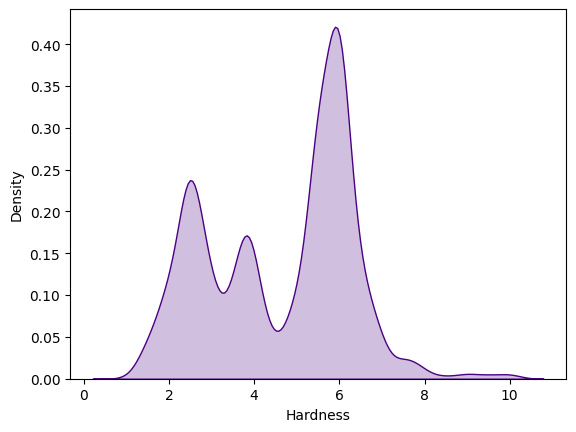

In [8]:
sns.kdeplot(data=train_df, x="Hardness", fill=True, color="indigo")

Проаналізувавши графік я роблю висновок, що змінна має мультимодальний розподіл.

Тепер поглянемо на інші змінні та проаналізуємо їх викиди.

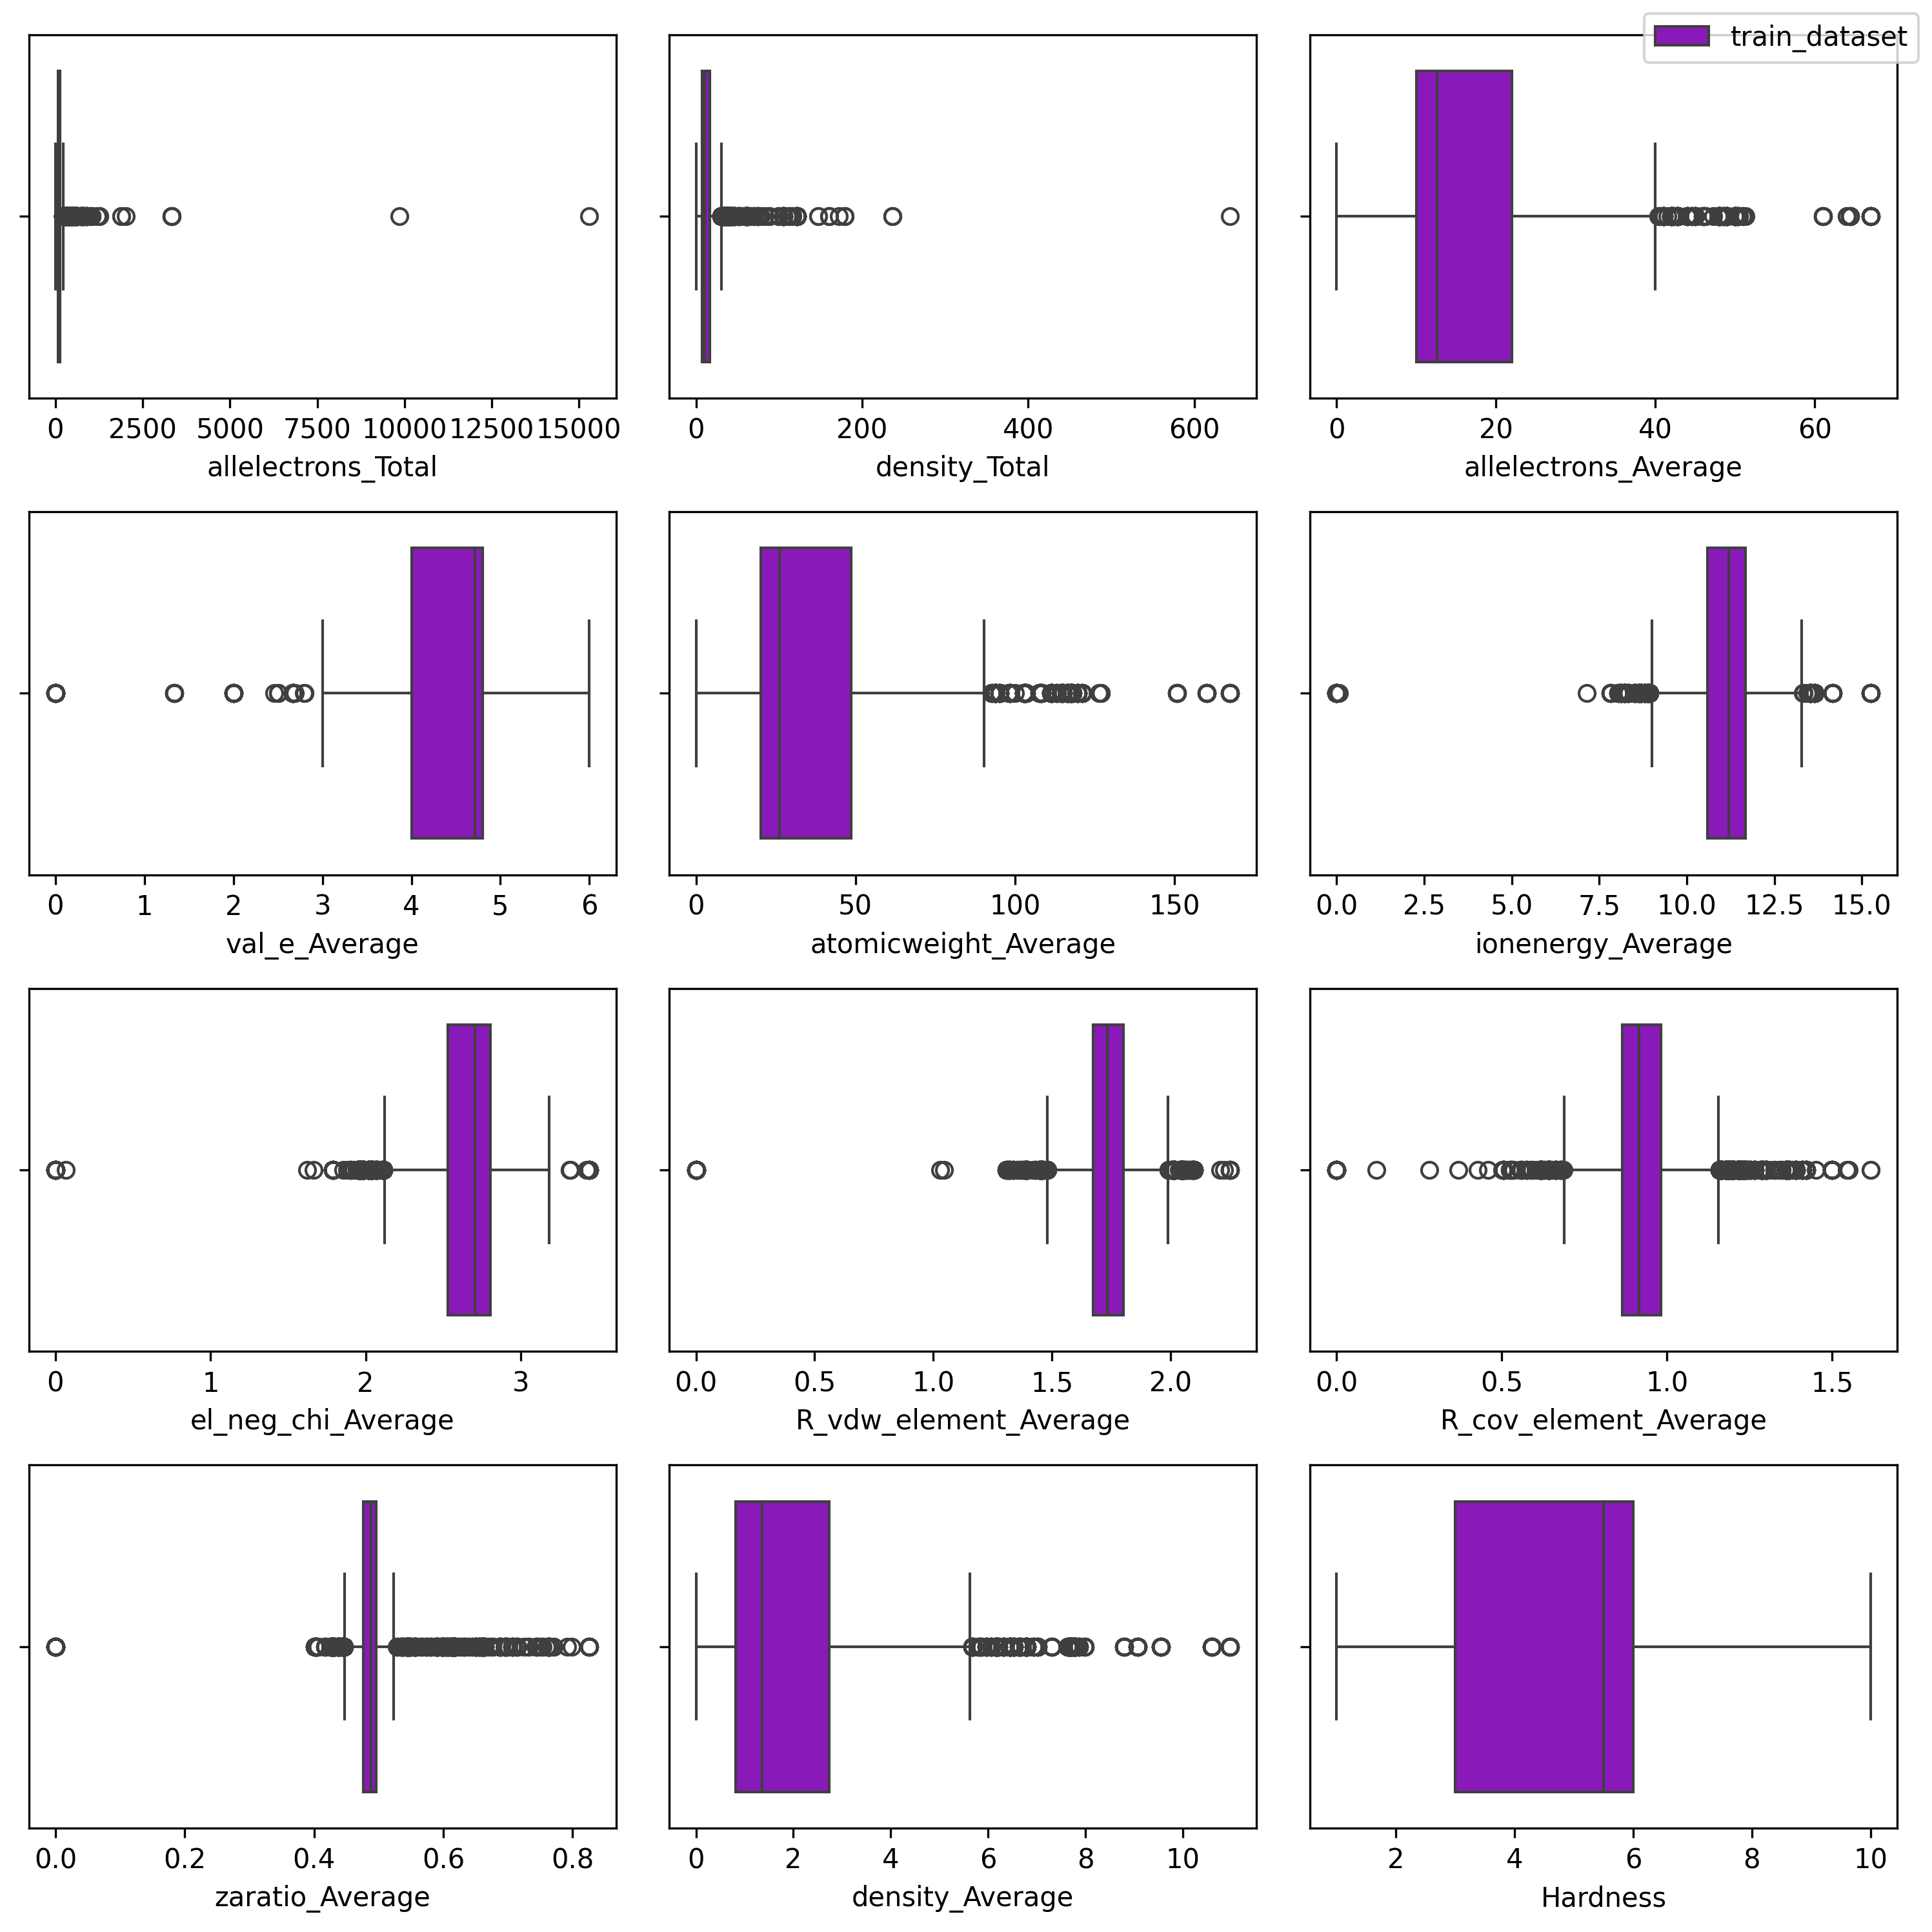

In [9]:
fig, ax = plt.subplots(int((len(train_df.columns)/3)), 3, figsize = (10, 10), dpi = 300)
ax = ax.flatten()

for i, column in enumerate(train_df.columns):
    sns.boxplot(x=train_df[column], ax=ax[i], color="darkviolet")

fig.legend(["train_dataset"])
plt.tight_layout()

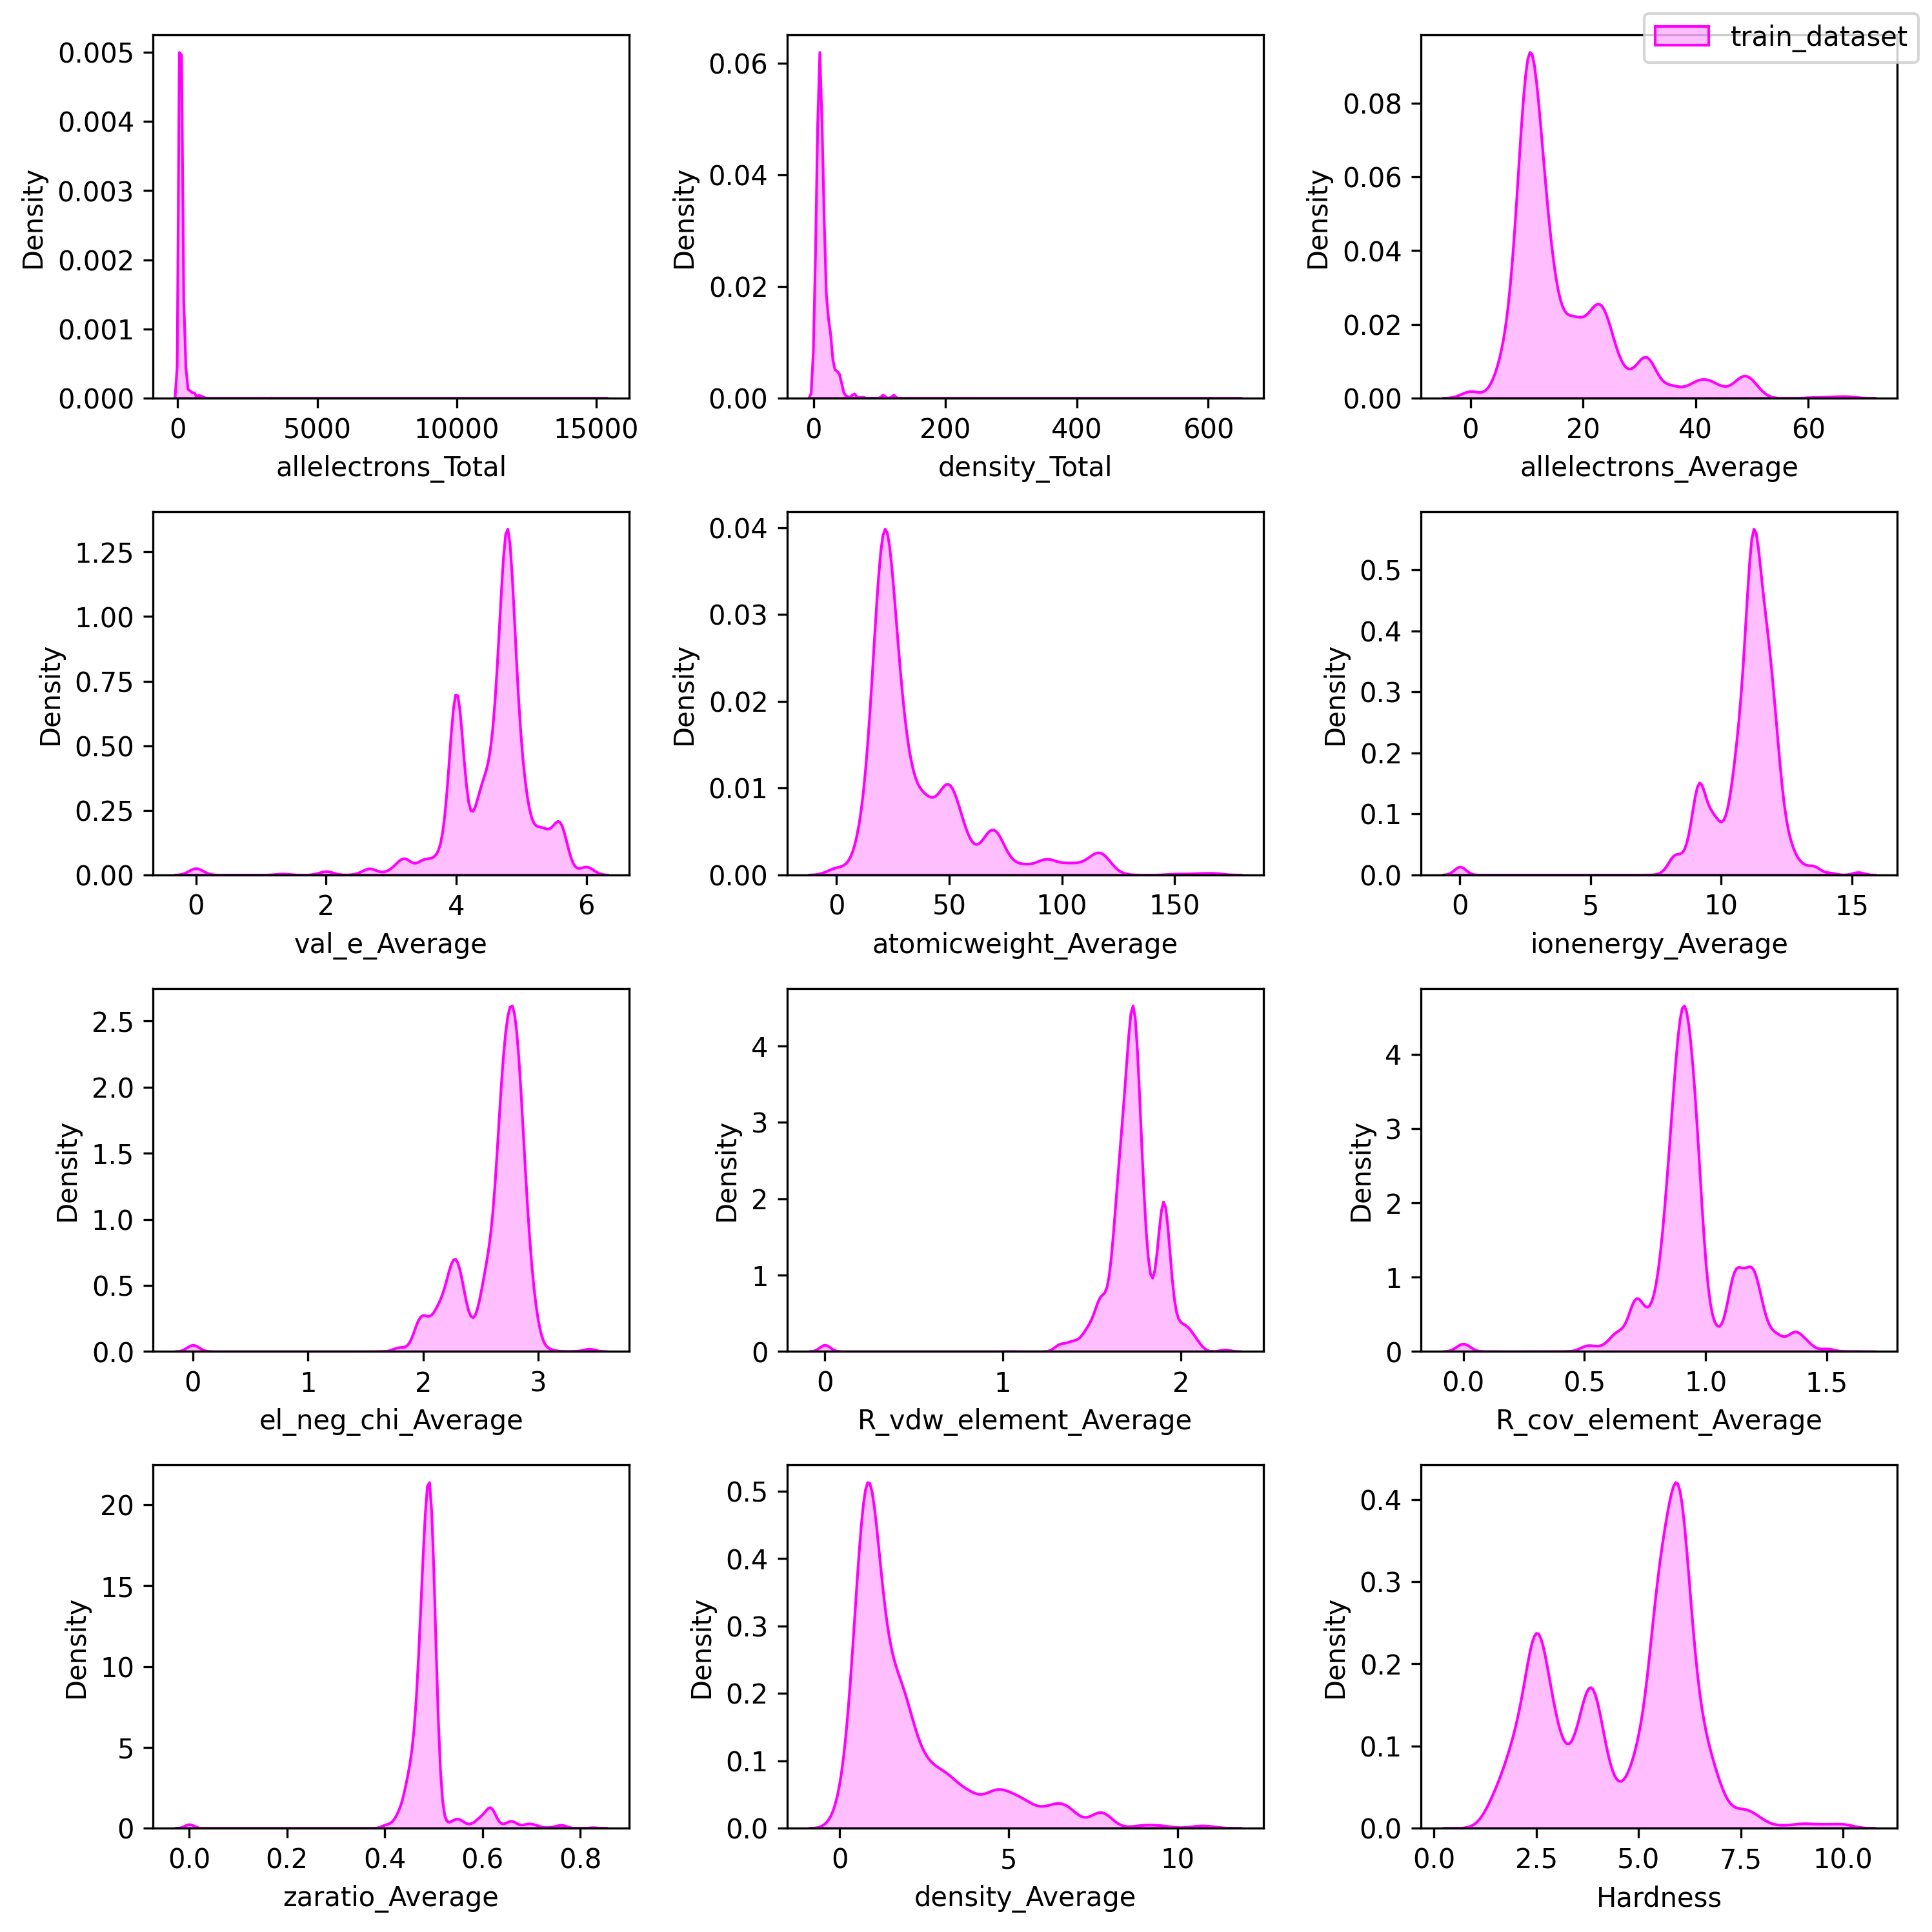

In [10]:
fig, ax = plt.subplots(int((len(train_df.columns)/3)), 3, figsize = (10, 10), dpi = 300)
ax = ax.flatten()

for i, column in enumerate(train_df.columns):
    sns.kdeplot(x=train_df[column], ax=ax[i], fill=True, color="magenta")

fig.legend(["train_dataset"])
plt.tight_layout()

In [11]:
def z_score(df):
    outliers = []
    threshold = 3

    mean = np.mean(df)
    std = np.std(df)

    for item in df:
        z_score = (item - mean) / std
        if np.abs(z_score) > threshold:
            outliers.append(item)
    return outliers

In [12]:
percentage = dict()
outliers_len = 0
all_values = train_df.shape[0] * train_df.shape[1]

for column in train_df.columns:
    outliers = z_score(train_df[column])
    percentage[column] = str(round((len(outliers) / train_df.shape[0]) * 100, 3)) + "%"
    outliers_len += len(outliers)

total_outlier_percent = outliers_len / all_values * 100

percentage = pd.DataFrame(percentage, index=[0]).T
percentage

,0
allelectrons_Total,0.442%
density_Total,1.24%
allelectrons_Average,2.008%
val_e_Average,1.172%
atomicweight_Average,2.575%
ionenergy_Average,0.961%
el_neg_chi_Average,0.653%
R_vdw_element_Average,0.673%
R_cov_element_Average,1.067%
zaratio_Average,2.393%


Майже всі дані мають невелику кількість викидів, які створюють зміщення розподілу. Для більшості змінних кількість викидів складає близько 1%, а це вважається гарним результатом.

В наступній комірці я реалізував видалення експліцитних викидів за допомогою правила IQR. В ході багатьох експериментів я прийшов до висновку, що це трохи покращує якість моделі на валідаційній вибірці.

In [13]:
Q1 = train_df.describe().quantile(0.25)
Q3 = train_df.describe().quantile(0.75)
IQR = Q3 - Q1
lower_lim = Q1 - 1.5 * IQR
upper_lim = Q3 + 1.5 * IQR

outliers_low = (train_df < lower_lim)
outliers_up = (train_df > upper_lim)

print("Кількість викидів по кожній змінній:")
print(train_df[(outliers_low | outliers_up)].count())
train_df = train_df[~(outliers_low | outliers_up)]

# Ми замінили викиди на NaN, тому тепер необхідно замінити пропуски медіаною.
# Тепер ми можемо ще раз поглянути на розподіл даних по змінних.
train_df = train_df.fillna(train_df.median())

Кількість викидів по кожній змінній:
allelectrons_Total        2
density_Total             1
allelectrons_Average      0
val_e_Average            71
atomicweight_Average     32
ionenergy_Average        76
el_neg_chi_Average       68
R_vdw_element_Average    68
R_cov_element_Average    77
zaratio_Average          62
density_Average          36
Hardness                  0
dtype: int64


Повторно побудуємо графіки розподілу даних після видалення викидів:

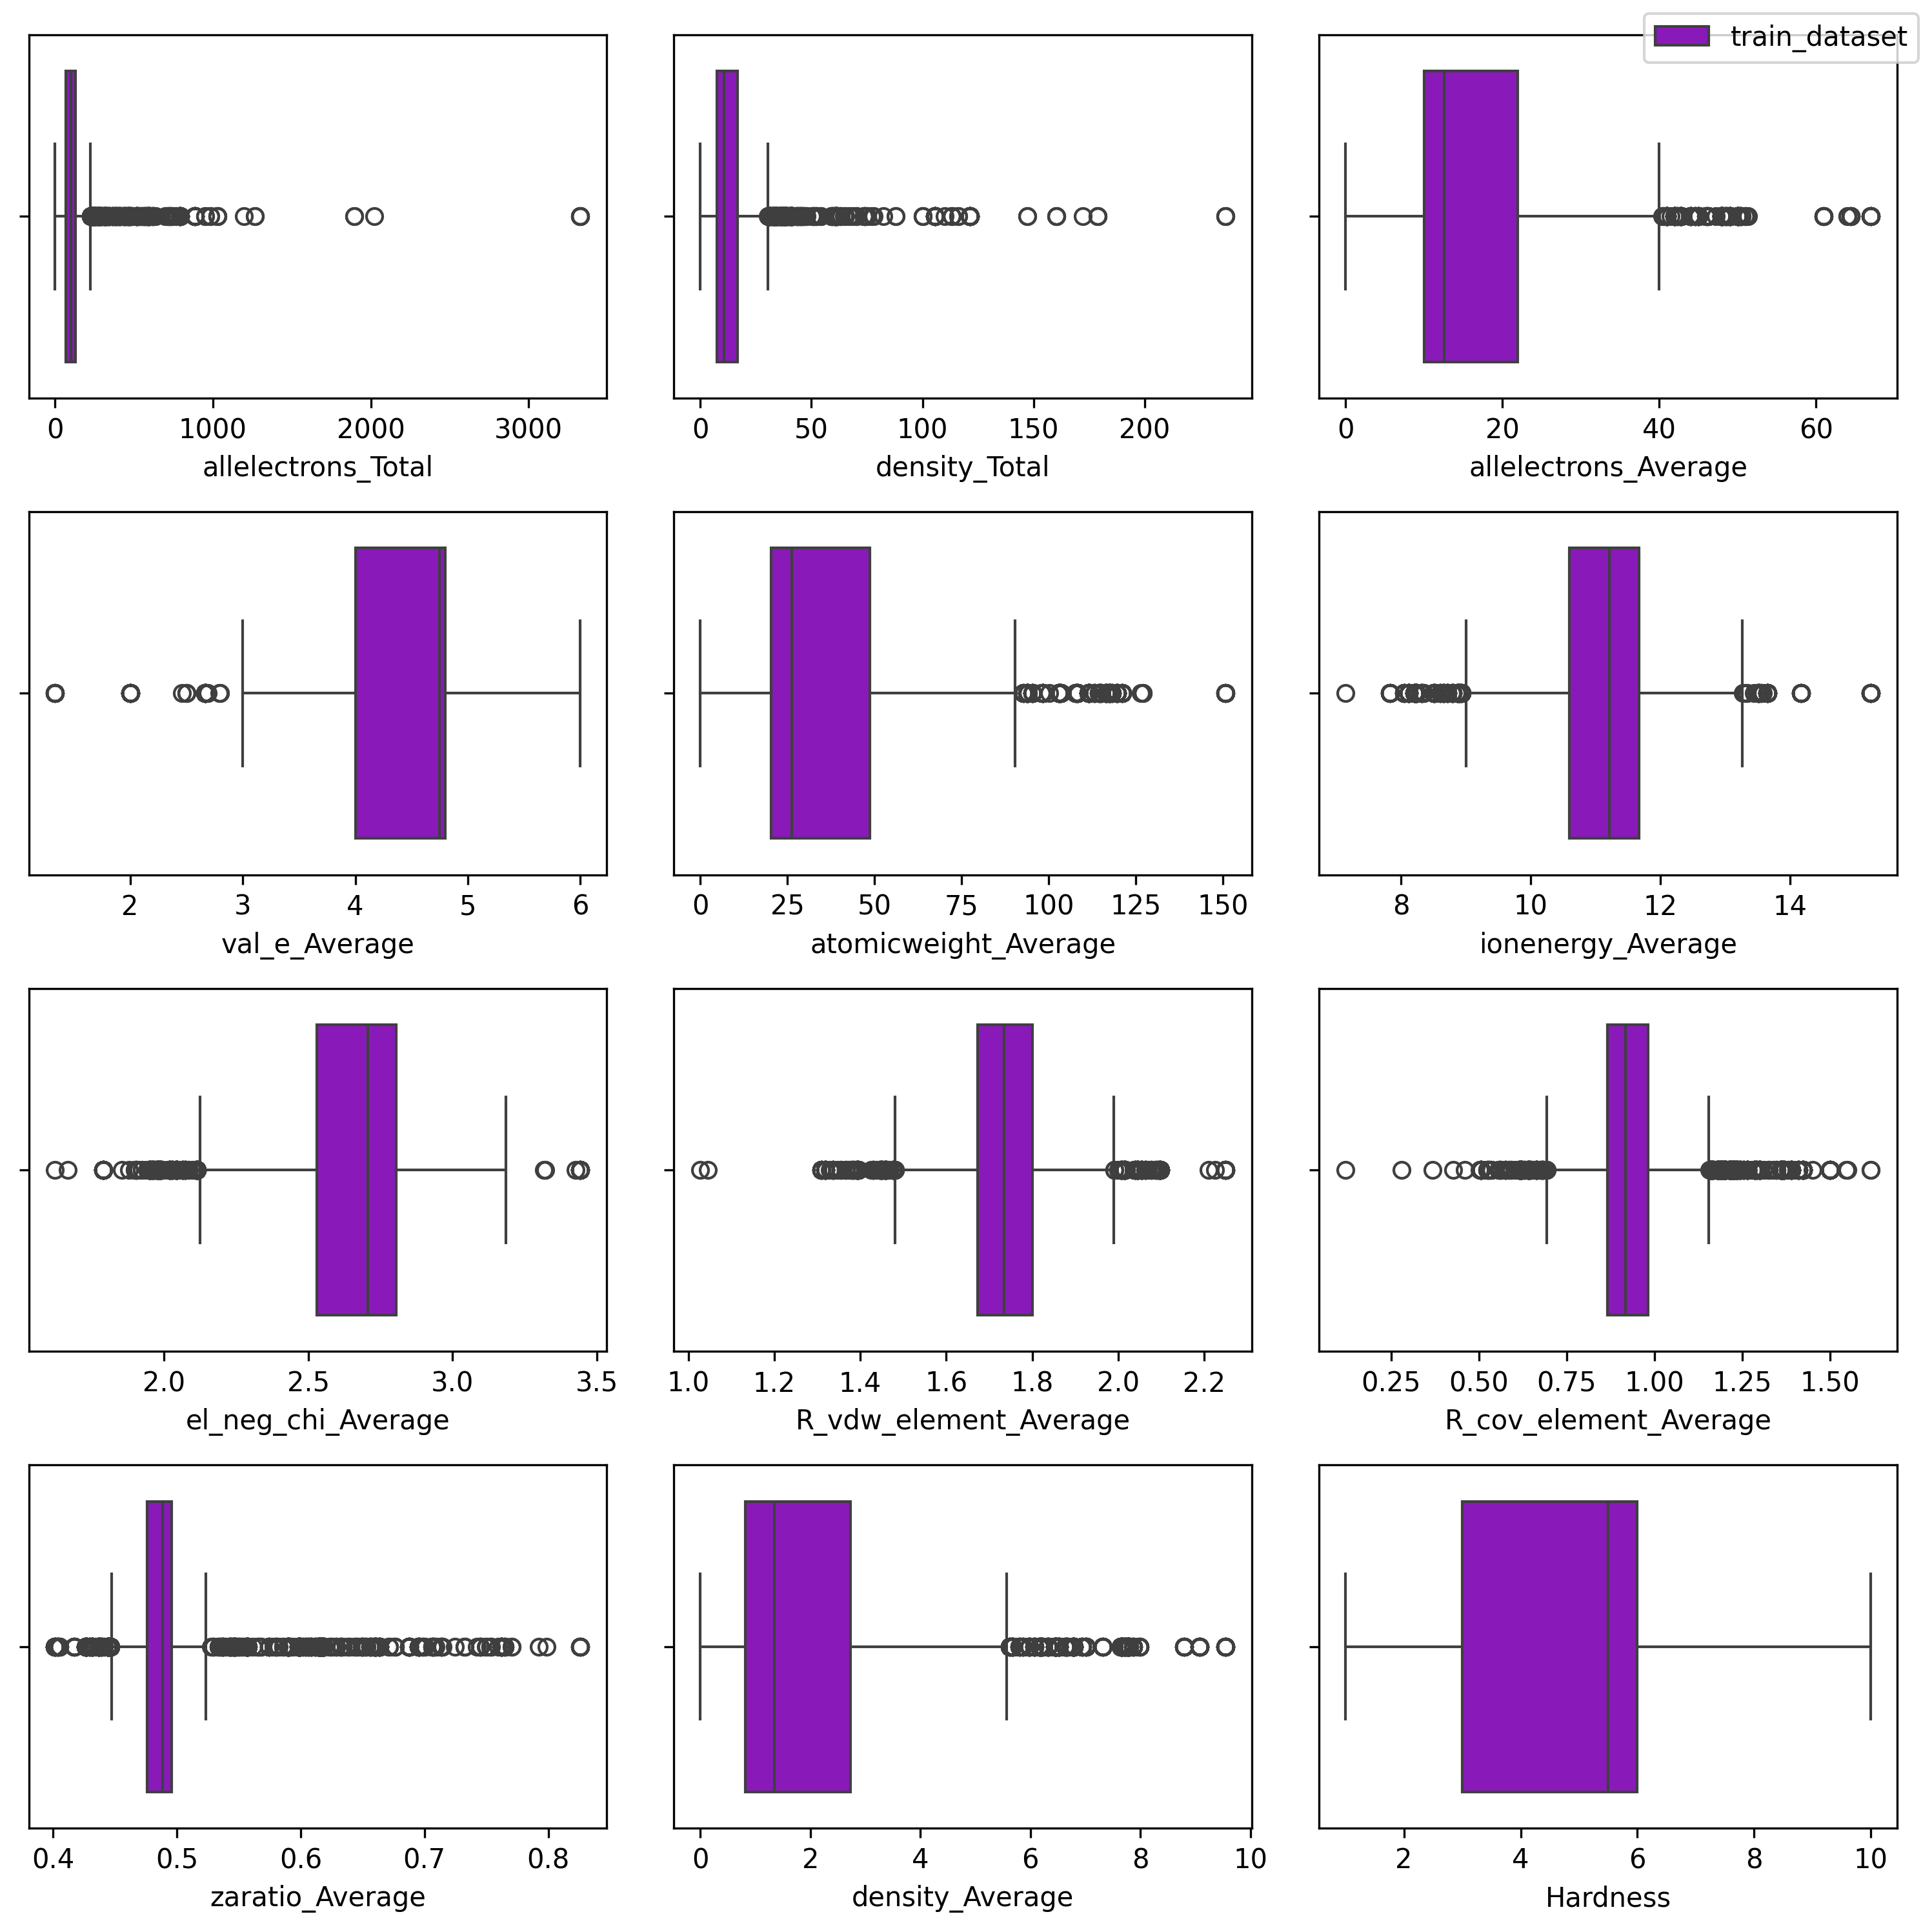

In [14]:
fig, ax = plt.subplots(int((len(train_df.columns)/3)), 3, figsize = (10, 10), dpi = 300)
ax = ax.flatten()

for i, column in enumerate(train_df.columns):
    sns.boxplot(x=train_df[column], ax=ax[i], color="darkviolet")

fig.legend(["train_dataset"])
plt.tight_layout()

**Кореляційний аналіз**

<Axes: >

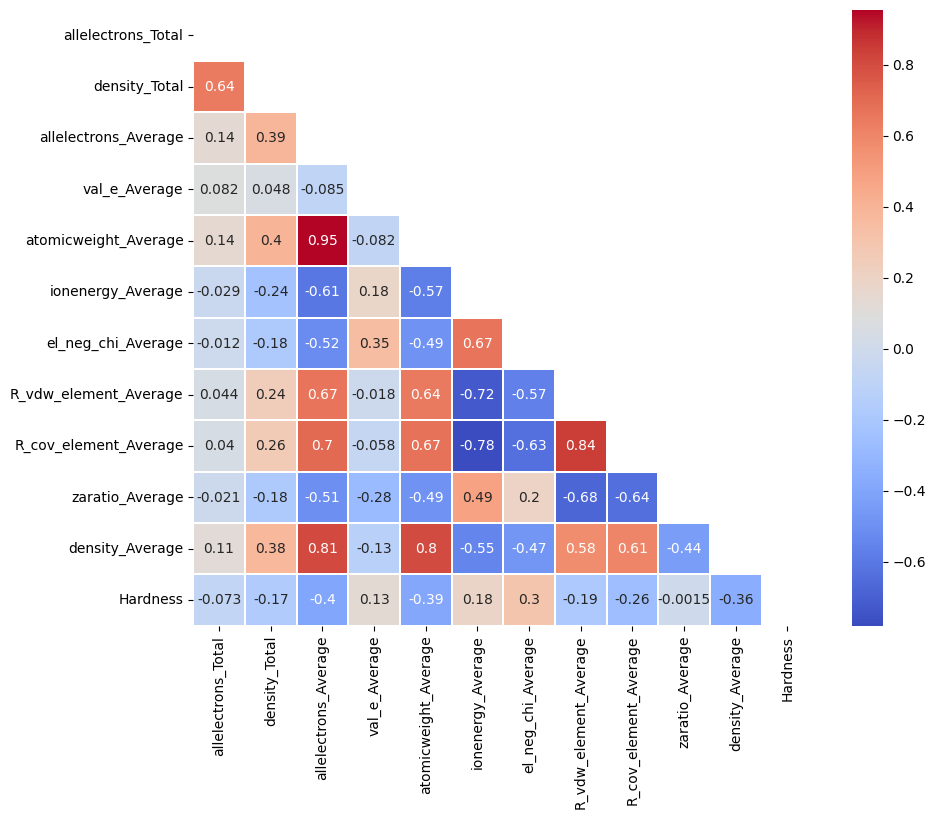

In [15]:
corr_matrix = train_df.corr()

plt.figure(figsize=(10, 8))
data_mask = np.triu(np.ones_like(corr_matrix, dtype = bool))
sns.heatmap(
    corr_matrix,
    linewidths=0.1,
    cmap="coolwarm",
    annot=True,
    mask = data_mask
)

Проаналізувавши матрицю корреляцій, я бачу:
- atomicweight_Average та allelectrons_Average є майже однаковими змінними (95% кореляції).
- R_cov_element_Average та R_vdw_element_Average мають сильну кореляцію (84% кореляції).
- density_Average, allelectrons_Average та atomicweight_Average також мають значну кореляцію (80-81% кореляції).
- **allelectrons_Average,  atomicweight_Average, density_Average мають найбільшу корреляцію за модулем зі змінною Hardness.**

Оскільки змінна allelectrons_Average сильно корелює зі змінною atomicweight_Average, ми могли б видалити першу з нашого датасету.
Проте в ході багатьох експериментів я прийшлов до висновку, що відсутність цієї змінної значного погіршує якість моделі.

**Тепер можна розбити дані на тренувальну та валідаційну вибірки**

In [ ]:
y = train_df['Hardness']
X = train_df.drop(columns='Hardness')

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=1)
print("Training X:", X_train.shape, "Training y:", y_train.shape)
print("Validation X:", X_val.shape, "Validation y:", y_val.shape)

Training X: (7805, 11) Training y: (7805,)
Validation X: (2602, 11) Validation y: (2602,)


: 

## KFold VS train_test_split



Тепер спробую порівняти класичний метод розбиття даних з крос-валідацією. Спочатку проведу розбиття даних за допомогою методу train_test_split і протестую на них лінійні моделі (з регуляризацією та без), а потім реалізую те ж саме, використовуючи крос-валідацію (метод KFold).

In [474]:
results_tts = []
results_cv = []

**Розбиття з train_test_split**

In [475]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
lr_predictions = linear_regression.predict(X_val)

lr_mse = mean_squared_error(y_val, lr_predictions)
lr_mae = mean_absolute_error(y_val, lr_predictions)
lr_medae = median_absolute_error(y_val, lr_predictions)
lr_r2 = r2_score(y_val, lr_predictions)

print("\n-------LinearRegression-------")
# print("Mean Squared Error:", lr_mse)
# print("Mean Absolute Error:", lr_mae)
print("Median Absolute Error:", lr_medae)
print("R^2 Score:", lr_r2)
results_tts.append((lr_medae, lr_r2))

ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_val)

ridge_mse = mean_squared_error(y_val, ridge_predictions)
ridge_mae = mean_absolute_error(y_val, ridge_predictions)
ridge_medae = median_absolute_error(y_val, ridge_predictions)
ridge_r2 = r2_score(y_val, ridge_predictions)

print("\n-------Ridge-------")
# print("Mean Squared Error:", ridge_mse)
# print("Mean Absolute Error:", ridge_mae)
print("Median Absolute Error:", ridge_medae)
print("R^2 Score:", ridge_r2)
results_tts.append((ridge_medae, ridge_r2))

lasso_model = Lasso()
lasso_model.fit(X_train, y_train)
lasso_predictions = lasso_model.predict(X_val)

lasso_mse = mean_squared_error(y_val, lasso_predictions)
lasso_mae = mean_absolute_error(y_val, lasso_predictions)
lasso_medae = median_absolute_error(y_val, lasso_predictions)
lasso_r2 = r2_score(y_val, lasso_predictions)

print("\n-------Lasso-------")
# print("Mean Squared Error:", lasso_mse)
# print("Mean Absolute Error:", lasso_mae)
print("Median Absolute Error:", lasso_medae)
print("R^2 Score:", lasso_r2)
results_tts.append((lasso_medae, lasso_r2))

en_model = ElasticNet()
en_model.fit(X_train, y_train)
en_predictions = en_model.predict(X_val)

en_mse = mean_squared_error(y_val, en_predictions)
en_mae = mean_absolute_error(y_val, en_predictions)
en_medae = median_absolute_error(y_val, en_predictions)
en_r2 = r2_score(y_val, en_predictions)

print("\n-------ElasticNet-------")
# print("Mean Squared Error:", en_mse)
# print("Mean Absolute Error:", en_mae)
print("Median Absolute Error:", en_medae)
print("R^2 Score:", en_r2)
results_tts.append((en_medae, en_r2))


-------LinearRegression-------
Median Absolute Error: 0.9580044549613627
R^2 Score: 0.24200336594071892

-------Ridge-------
Median Absolute Error: 0.9644214053551501
R^2 Score: 0.24229063233720205

-------Lasso-------
Median Absolute Error: 1.0983352992705968
R^2 Score: 0.15559308971911978

-------ElasticNet-------
Median Absolute Error: 1.099466983626435
R^2 Score: 0.15875225781376845


**Розбиття з KFold**

In [476]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=1)

linear_regression = LinearRegression()
ridge_model = Ridge()
lasso_model = Lasso()
en_model = ElasticNet()

scoring = {'r2': make_scorer(r2_score), 'medae': make_scorer(median_absolute_error)}

lr_r2_results = cross_val_score(linear_regression, X_train, y_train, cv=kf, scoring=scoring['r2'])
lr_medae_results = cross_val_score(linear_regression, X_train, y_train, cv=kf, scoring=scoring['medae'])

print("\n-------LinearRegression-------")
print(f'R^2: {lr_r2_results.mean()}')
print(f'MedAE: {lr_medae_results.mean()}')
results_cv.append((lr_medae_results.mean(), lr_r2_results.mean()))

ridge_r2_results = cross_val_score(ridge_model, X_train, y_train, cv=kf, scoring=scoring['r2'])
ridge_medae_results = cross_val_score(ridge_model, X_train, y_train, cv=kf, scoring=scoring['medae'])

print("\n-------Ridge-------")
print(f'R^2: {ridge_r2_results.mean()}')
print(f'MedAE: {ridge_medae_results.mean()}')
results_cv.append((ridge_medae_results.mean(), ridge_r2_results.mean()))


lasso_r2_results = cross_val_score(lasso_model, X_train, y_train, cv=kf, scoring=scoring['r2'])
lasso_medae_results = cross_val_score(lasso_model, X_train, y_train, cv=kf, scoring=scoring['medae'])

print("\n-------Lasso-------")
print(f'R^2: {lasso_r2_results.mean()}')
print(f'MedAE: {lasso_medae_results.mean()}')
results_cv.append((lasso_medae_results.mean(), lasso_r2_results.mean()))


en_r2_results = cross_val_score(en_model, X_train, y_train, cv=kf, scoring=scoring['r2'])
en_medae_results = cross_val_score(en_model, X_train, y_train, cv=kf, scoring=scoring['medae'])

print("\n-------ElasticNet-------")
print(f'R^2: {en_r2_results.mean()}')
print(f'MedAE: {en_medae_results.mean()}')
results_cv.append((en_medae_results.mean(), en_r2_results.mean()))



-------LinearRegression-------
R^2: 0.24465382711208816
MedAE: 0.9670387866418583

-------Ridge-------
R^2: 0.24412365769426803
MedAE: 0.9680499650677048

-------Lasso-------
R^2: 0.15429735075779025
MedAE: 1.0949294382229298

-------ElasticNet-------
R^2: 0.15692504175453362
MedAE: 1.0871756605351337


In [477]:
results_tts

[(0.9580044549613627, 0.24200336594071892),
 (0.9644214053551501, 0.24229063233720205),
 (1.0983352992705968, 0.15559308971911978),
 (1.099466983626435, 0.15875225781376845)]

**Висновки щодо розбиття на вибірки**

З проведеного експерименту я бачу, що крос-валідація допомагає запобігти перенавчанню та дозволяє досягти кращого значення MedAE та R^2 для:
- лінійної регресії без регулризації
- Ridge

Значення метрик для моделей залишаються кращими при класичному розбитті за допомогою train_test_split для моделей:
- Lasso
- ElasticNet

Порівняльна таблиця представлена нижче.

In [478]:
results_tts = pd.DataFrame(results_tts, columns=['MedAE', 'R^2'], index=["LR", "Ridge", "Lasso", "ElasticNet"]).T
results_cv = pd.DataFrame(results_cv, columns=['MedAE', 'R^2'], index=["LR", "Ridge", "Lasso", "ElasticNet"]).T

print("-----train_test_split-----")
print(results_tts)
print("\n-----KFold-----")
print(results_cv)

-----train_test_split-----
             LR     Ridge     Lasso  ElasticNet
MedAE  0.958004  0.964421  1.098335    1.099467
R^2    0.242003  0.242291  0.155593    0.158752

-----KFold-----
             LR     Ridge     Lasso  ElasticNet
MedAE  0.967039  0.968050  1.094929    1.087176
R^2    0.244654  0.244124  0.154297    0.156925


## Regularization

**Ridge (L2 регуляризація)**

Наступний код демонструє вплив коефіцієнту регуляризації на порядок значень вагових коефіцієнтів.
В якості експерименту я ініціалізую десять моделей з L2 регуляризацією різного ступеню впливу та одну модель без регуляризації.

In [479]:
alphas = list(np.logspace(-7, 4, 10))    # ініціалізація коефіцієнтів сили регуляризації
models = []
coefs = []
print("Коефіцієнти сили регуляризації:", alphas)

for alpha in alphas:
    ridge_model = Ridge(alpha=alpha).fit(X_train, y_train)
    models.append(ridge_model)
    coefs.append(ridge_model.coef_)

models.append(LinearRegression().fit(X_train, y_train))   # додаю модель без регуляризації для порівняння якості

print("Кількість моделей:", len(models))

coefs = np.vstack(coefs).T    # групування коефіцієнтів для кожної моделі

scores = []
scores.append(
        {
            'alpha': '-',
            'train_r2': models[-1].score(X_train, y_train),
            'validation_r2': models[-1].score(X_val, y_val)
        }
    )   # додаю модель без регуляризації

for i, m in enumerate(models[:-1]):
    alpha = alphas[i]
    scores.append(
        {
            'alpha': round(alpha, 4),
            'train_r2': m.score(X_train, y_train),
            'validation_r2': m.score(X_val, y_val)
        }
    )
scores = pd.DataFrame(scores)
scores

Коефіцієнти сили регуляризації: [1e-07, 1.6681005372000591e-06, 2.782559402207126e-05, 0.0004641588833612782, 0.007742636826811277, 0.12915496650148853, 2.1544346900318865, 35.9381366380464, 599.4842503189421, 10000.0]
Кількість моделей: 11


,alpha,train_r2,validation_r2
0,-,0.247358,0.242003
1,0.0,0.247358,0.242003
2,0.0,0.247358,0.242003
3,0.0,0.247358,0.242003
4,0.0005,0.247358,0.242004
5,0.0077,0.247358,0.242010
6,0.1292,0.247348,0.242106
7,2.1544,0.245607,0.241698
8,35.9381,0.221503,0.220327
9,599.4843,0.194965,0.193826


З таблиці метрик я бачу, що найкращий результат на валідаційній вибірці має модель під номером 6 **(R^2 = 0.242106)**. Одже найоптимальніший коефіцієнт сили для L2 регуляризації дорівнює **0.129155**.

Наступний графік наглядно демонструє, як зменшуються вагові коефіцієнти при L2 регуляризації з різною силою alpha.

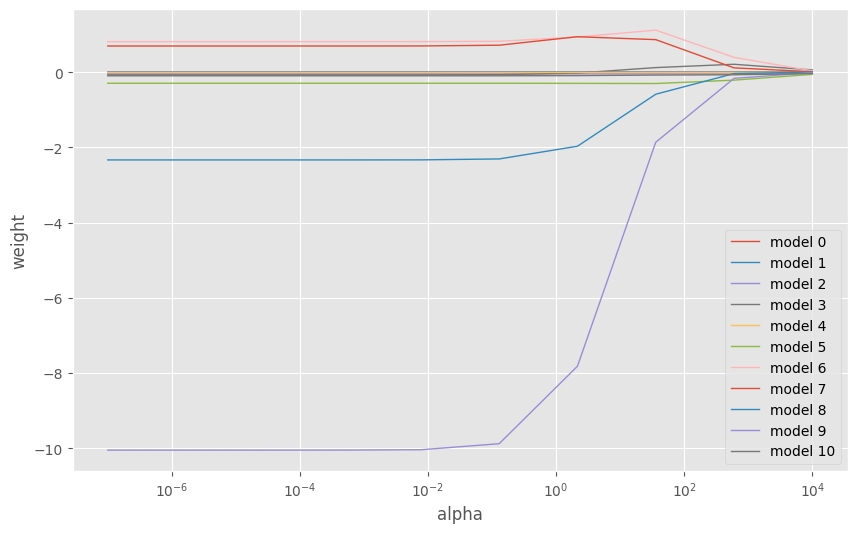

In [480]:
figure, ax = plt.subplots(figsize=(10, 6))

for i, coef in enumerate(coefs):
    ax.plot(alphas, coef, linewidth=1, label=f"model {i}")

plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('weight')
plt.legend()

Наступний графік показує, як змінюється значення метрики R^2 в залежності від значення коефіцієнту сили регуляризації alpha.

Text(0, 0.5, 'R^2')

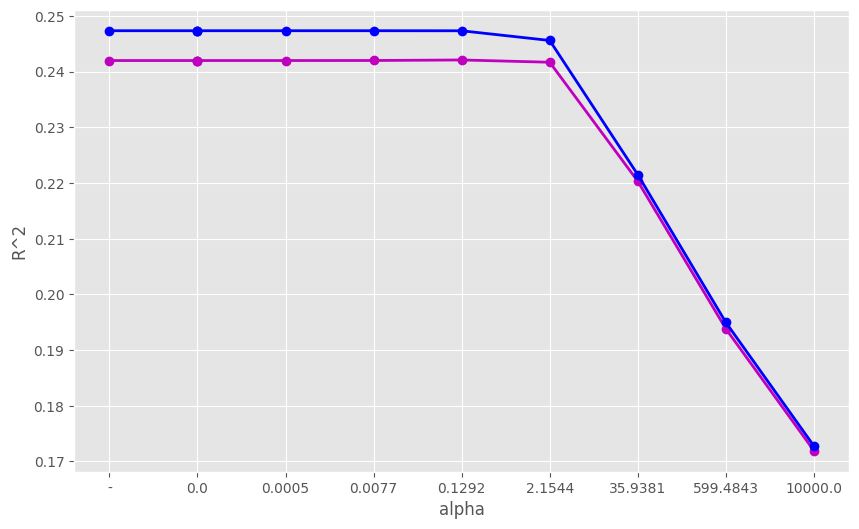

In [481]:
figure, ax = plt.subplots(figsize=(10, 6))

ax.plot(scores["alpha"].tolist(), scores["validation_r2"].tolist(), "-om", linewidth=2)
ax.plot(scores["alpha"].tolist(), scores["train_r2"].tolist(), "-ob", linewidth=2)

plt.xlabel('alpha')
plt.ylabel('R^2')

**Lasso (L1 регуляризація)**

Проведемо подібний порівняльний експеримент для L1 регуляризації.


In [482]:
alphas = list(np.logspace(-3, 2, 10))
models = []
coefs = []

print("Коефіцієнти сили регуляризації:", alphas)

for alpha in alphas:
    lasso_model = Lasso(alpha=alpha).fit(X_train, y_train)
    models.append(lasso_model)
    coefs.append(lasso_model.coef_)

models.append(LinearRegression().fit(X_train, y_train))

coefs = np.vstack(coefs).T    # групування коефіцієнтів для кожної моделі

print("Кількість моделей:", len(models))

scores = []
scores.append(
        {
            'alpha': '-',
            'train_r2': models[-1].score(X_train, y_train),
            'validation_r2': models[-1].score(X_val, y_val)
        }
    )   # додаю модель без регуляризації

for i, m in enumerate(models[:-1]):
    alpha = alphas[i]
    scores.append(
        {
            'alpha': round(alpha, 4),
            'train_r2': m.score(X_train, y_train),
            'validation_r2': m.score(X_val, y_val)
        }
    )
scores = pd.DataFrame(scores)
scores

Коефіцієнти сили регуляризації: [0.001, 0.003593813663804626, 0.01291549665014884, 0.046415888336127795, 0.1668100537200059, 0.5994842503189409, 2.1544346900318843, 7.742636826811277, 27.825594022071257, 100.0]
Кількість моделей: 11


,alpha,train_r2,validation_r2
0,-,0.247358,0.242003
1,0.001,0.246820,0.241650
2,0.0036,0.240801,0.236280
3,0.0129,0.201327,0.199316
4,0.0464,0.178286,0.176814
5,0.1668,0.162149,0.161076
6,0.5995,0.157491,0.157497
7,2.1544,0.152951,0.154368
8,7.7426,0.120591,0.124183
9,27.8256,0.000000,-0.000174


У випадку з L1 регуляризацією я бачу, що найкраще значення R^2 у першої моделі, якою є звичайна лінійна регресія без регуляризації.

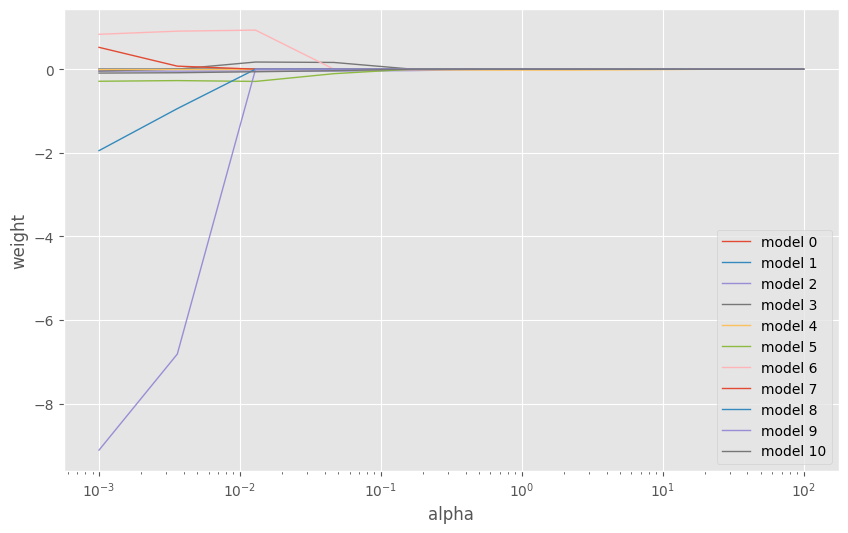

In [483]:
figure, ax = plt.subplots(figsize=(10, 6))

for i, coef in enumerate(coefs):
    ax.plot(alphas, coef, linewidth=1, label=f"model {i}")

plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('weight')
plt.legend()


Text(0, 0.5, 'R^2')

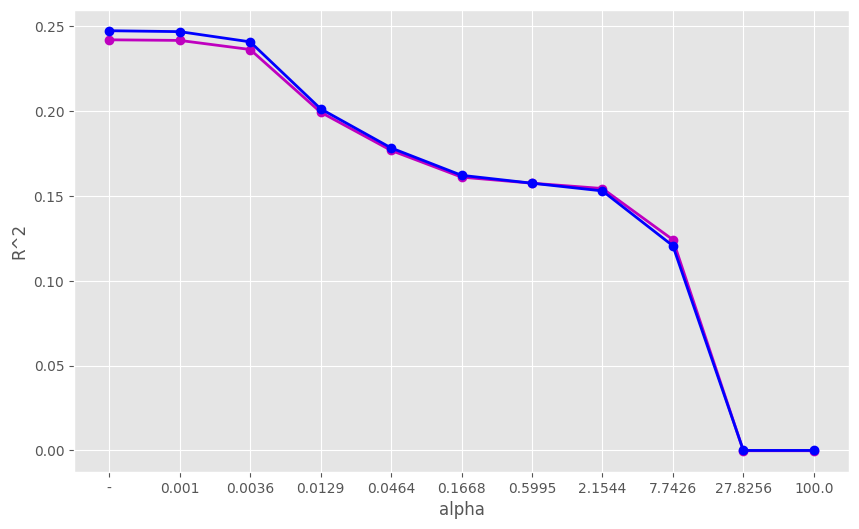

In [484]:
figure, ax = plt.subplots(figsize=(10, 6))

ax.plot(scores["alpha"].tolist(), scores["validation_r2"].tolist(), "-om", linewidth=2)
ax.plot(scores["alpha"].tolist(), scores["train_r2"].tolist(), "-ob", linewidth=2)

plt.xlabel('alpha')
plt.ylabel('R^2')

**Висновки щодо регуляризації**

В ході експерименту я провів детальний аналіз впливу коефіцієнту сили кореляції alpha на якість роботи моделі. Загалом було зроблено два висновки:
1. При L2 регуляризації модель досягає найбільшої точності зі значенням коефіцієнту сили 0.129155.
2. L1 регуляризація не є необхідною при роботі з нашими даними, адже порівняльний аналіз довів, що найкраще значення R^2 має модель звчайної лінійної регресії без регуляризації. Отже вона тільки погіршує точність роботи моделі.




## PolynomialFeatures

In [485]:
degree = 4
poly = PolynomialFeatures(degree, include_bias=(degree == 0))
train_X_poly = poly.fit_transform(X_train)
val_X_poly = poly.fit_transform(X_val)
df_x_poly = poly.fit_transform(X)

print("Нова розмірність X_train:", train_X_poly.shape)
print("Нова розмірність X_val:", val_X_poly.shape)

Нова розмірність X_train: (7805, 1364)
Нова розмірність X_val: (2602, 1364)


In [486]:
models = [LinearRegression(), Lasso(), Ridge()]

poly_degrees = [1, 2, 3, 4, 5]

for model in models:
    metrics_res = {
        'train':
          {
            'MedAE': [],
            'R^2': []
          },
        'val': {
            'MedAE': [],
            'R^2': []
        }
    }

    for poly_degree in poly_degrees:
        poly = PolynomialFeatures(poly_degree)
        train_X_poly = poly.fit_transform(X_train)
        val_X_poly = poly.fit_transform(X_val)


        model.fit(train_X_poly, y_train)

        prediction_train = model.predict(train_X_poly)
        prediction_val = model.predict(val_X_poly)

        metrics_res["train"]['MedAE'].append(median_absolute_error(y_train, prediction_train))
        metrics_res["train"]['R^2'].append(r2_score(y_train, prediction_train))

        metrics_res["val"]['MedAE'].append(median_absolute_error(y_val, prediction_val))
        metrics_res["val"]['R^2'].append(r2_score(y_val, prediction_val))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.539e+03, tolerance: 2.194e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.791e+03, tolerance: 2.194e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.265e+03, tolerance: 2.194e

Як приклад розглянемо значення метрик MedAE та R^2 для моделі Ridge.

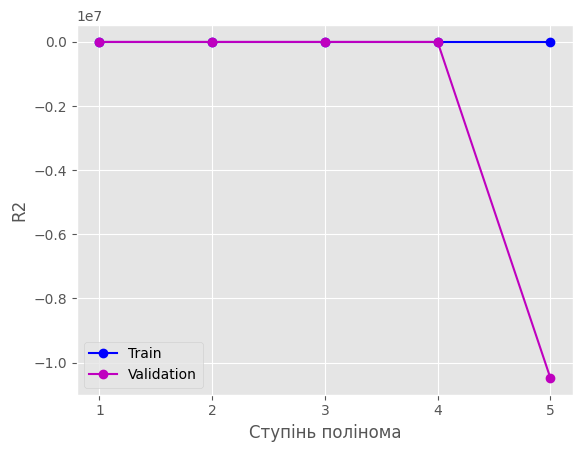

In [500]:
plt.plot(poly_degrees, metrics_res['train']['R^2'], '-ob', label='Train')
plt.plot(poly_degrees, metrics_res['val']['R^2'], '-om', label='Validation')
plt.xlabel('Ступінь полінома')
plt.ylabel('R2')
plt.xticks(poly_degrees)
plt.legend()
plt.show()

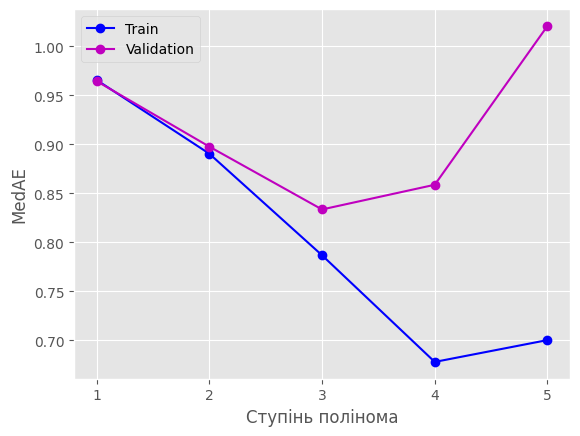

In [501]:
plt.plot(poly_degrees, metrics_res['train']['MedAE'], '-ob', label='Train')
plt.plot(poly_degrees, metrics_res['val']['MedAE'], '-om', label='Validation')
plt.xlabel('Ступінь полінома')
plt.ylabel('MedAE')
plt.xticks(poly_degrees)
plt.legend()
plt.show()

**Висновок щодо використання полінома**


Отримані результати вказують на те, що використання поліномів другого степеня у лінійній регресії дозволяє покращити значення метрик моделі на валідаційній та тренувальній вибірках. Проте, подальше збільшення степеня полінома призводить до явища перенавчання.

## Conclusions

Після детального аналізу моделей лінійної регресії можу зробити наступні висновки.
- Дані
  1. Дані не містять пропускі;
  2. Для більшості змінних кількість викидів складає близько 1%;
  3. Видалення експліцитних викидів дає кращий результат роботи всіх лінійних моделей;
  4. allelectrons_Average сильно корелює зі змінною atomicweight_Average, проте видалення кожної погіршує загальну якість моделі.

- Розбиття даних
  1. Крос-валідація допомагає запобігти перенавчанню та дозволяє досягти кращого значення метрик для моделей лінійної регресії без регулризації Ridge;
  2. Значення метрик для моделей залишаються кращими при класичному розбитті за допомогою train_test_split для моделей Lasso та ElasticNet.

- Регуляризація
  1. При L2 регуляризації модель досягає найбільшої точності зі значенням коефіцієнту сили 0.129155;
  2. L1 регуляризація погіршує точність роботи моделі. Тому для наших даних краще використовувати L2.

- Використання поліному
  1. Збільшення ступеня полінома часто призводить до перенавчання моделі, що проявляється в надмірній чутливості до вихідних даних і може погіршити її узагальнюючі можливості. Один з способів зменшення цього ефекту - застосування регуляризації.
  2. Оптимальний ступінь поліному, при якому не відбувається перенавчання, дорівнює 2.







